<img src="dsci512_header.png" width="600">

# Lecture 5

In [1]:
import numpy as np
import networkx as nx
from collections import Counter

In [2]:
# The defaults are hard to see on a projector in class
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
%config InlineBackend.figure_formats = ['svg']

draw_params = {
    "node_color": "pink",
    "font_size": 16,
    "with_labels": True,
    "arrowsize": 30,
    # "width": 1
    # "node_size": 200
}

Outline:

- Graphs intro (5 min)
- Graph types (5 min)
- Graph searches: recursive implementation (25 min)
- Break (5 min)
- Stacks and queues (5 min)
- Graph searches: iterative implementation (20 min)
- Activities (time-permitting)

## Learning objectives

- Map real-world problems to various kinds of various kinds of graphs (directed/undirected, weighted/unweighted).
- Perform breadth-first and depth-first searches in graphs.
- Compare/contrast BFS and DFS.
- Use Stack and Queue data structures in implementing DFS and BFS.
- Find the running times of graph algorithms as a function of the number of vertices and edges in a graph.

## Graphs intro (5 min)

Trees allowed us to represent hierarchical relationships. However, many relationships are not hierarchical:

- friendships (on Facebook, Twitter, or in real life)
- connections between machines on the internet
- direct flight connections between airports
- etc.

A graph consists of: 

- A set of _vertices_ or _nodes_
- A set of pairs of vertices, called _edges_

In [3]:
G = nx.Graph()

G.add_node("A")
G.add_node("B")
G.add_node("C")
G.add_node("D")
G.add_node("E")

G.add_edge("A", "B")
G.add_edge("B", "C")
G.add_edge("C", "D")
G.add_edge("D", "E")
G.add_edge("E", "A")
G.add_edge("A", "C")
G.add_edge("B", "D")
G.add_edge("C", "E")

- The graph package we're using, `networkx`, randomly visalizes the graph each time.
    - By re-running the next cell, we can see a few equivalent representations.
    - They are all the same graph!
    - See [`networkx.draw` documentation](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html).
    - Note: if you are interested, there's an Altair interface to `networkx`: [nx_altair](https://github.com/Zsailer/nx_altair).

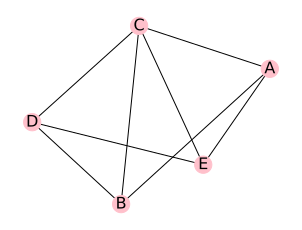

In [8]:
nx.draw(G, **draw_params)

Note: we can set the random seed if we want a fixed drawing:

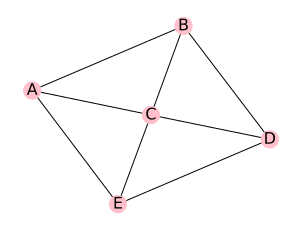

In [5]:
nx.draw(G, **draw_params, pos=nx.spring_layout(G, seed=5))

(Jupyter note: I had to specify "Disable Scrolling for Outputs" to make this look nicer.)

Some graph terminology:

- The _degree_ of a vertex is the number of edges connected to it.
  - Above, "B" has degree 3 and "C" has degree 4.
- A graph is _complete_ if every pair of vertices is joined by an edge.
  - The graph above is not complete because "B" and "E" are not directly connected (same with "A" and "D").

We can make it complete as follows:

In [9]:
G.add_edge("A", "D")
G.add_edge("B", "E")

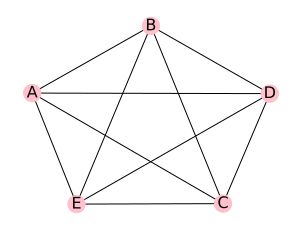

In [10]:
nx.draw(G, **draw_params, pos=nx.spring_layout(G, seed=5))

Below is another example of a complete graph, this time with 4 vertices.

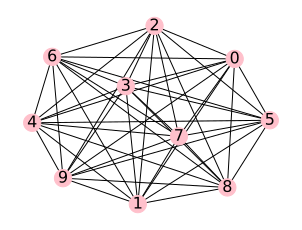

In [11]:
complete = nx.complete_graph(10)

nx.draw(complete, **draw_params)

More terminology:

- A graph is _connected_ if there is exists a path between any pair of nodes.
  - Below is an example disconnected graph. 

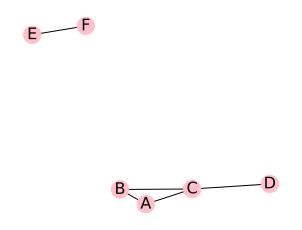

In [12]:
disconnected = nx.Graph()

disconnected.add_node("A")
disconnected.add_node("B")
disconnected.add_node("C")
disconnected.add_node("D")
disconnected.add_node("E")
disconnected.add_node("F")

disconnected.add_edge("A", "B")
disconnected.add_edge("A", "C")
disconnected.add_edge("D", "C")
disconnected.add_edge("B", "C")

disconnected.add_edge("E", "F")

nx.draw(disconnected, **draw_params)

## Graph types (5 min)

#### Undirected graphs

- This is what we've been looking at so far.
- Saying "there is an edge from A to B" is the same as saying "there is an edge from B to A"
- You can try this out in `networkx`.

#### Directed graphs

- Sometimes, relationships are directed (e.g. Twitter).
- This gives us a directed graph. We typically draw the direction with an arrow.
- Example:


In [13]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")
G.add_edge("A", "C")

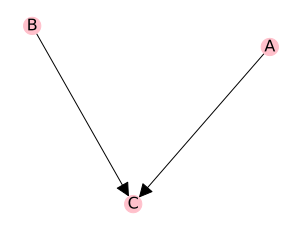

In [14]:
nx.draw(G, **draw_params)

Now let's reverse the direction of the edge from "B" to "C":

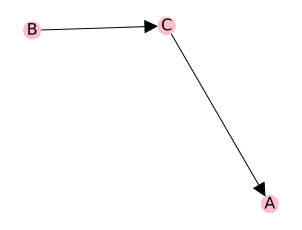

In [15]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")
G.add_edge("C", "A")

nx.draw(G, **draw_params)

- This is a fundamentally different graph. 
- The choice of graph type depends on the situation you're modelling. 
  - The MDS prerequisite graph is directed.

<img src="mds.png" width="900">

- Note that this is a directed graph, NOT a tree, because nodes can have multiple parents.

- Directed graphs can also have reciprocal connections:

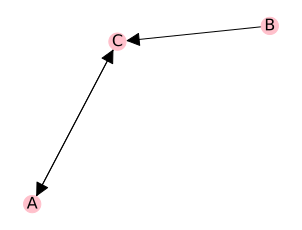

In [16]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")

# add a 2-way edge
G.add_edge("C", "A")
G.add_edge("A", "C")

nx.draw(G, **draw_params)

- Here, we have a double-headed arrow between A and C. 
- In an undirected graph, it wouldn't have made sense to have both 

```python
G.add_edge("C", "A")
G.add_edge("A", "C")
```

because one would be sufficient.

- Directed graphs also can have self-connections.
  - `networkx` supports them but it doesn't draw them properly.
  - You will see these when getting to Markov chains in DSCI 575.

#### Unweighted graphs

All the graphs above are "unweighted" because all edges are equal.

#### Weighted graphs

Both undirected and directed graphs can have weighted edges.

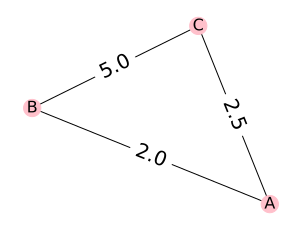

In [17]:
G = nx.Graph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("A", "B", weight=2.0)
G.add_edge("B", "C", weight=5.0)
G.add_edge("C", "A", weight=2.5)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20);

Above: undirected, weighted graph.

Below: directed, weighted graph.

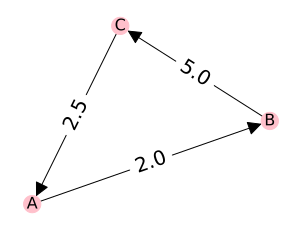

In [18]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("A", "B", weight=2.0)
G.add_edge("B", "C", weight=5.0)
G.add_edge("C", "A", weight=2.5)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20);

Examples where graphs can be used to model a situation:

- Flights between airports: weights can be cost or flight time between destinations.
  - Now we definitely want a directed graph, as the cost/time may depend on the direction.
  - Useful problem: minimum cost path from $A$ to $B$. This is called the [shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem).
- Countries.
  - Edge weights could be number of dual citizens (undirected).
  - Or trade/immigration in each direction (directed).
  - The weights could be the trade volume.

## Graph searches: recursive implementation (25 min)

Next, we'll discuss some algorithms performed on graphs.

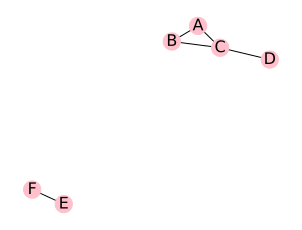

In [19]:
# pappus = nx.pappus_graph()
# nx.draw(pappus, with_labels=True, arrowsize=40)

# erg = nx.erdos_renyi_graph(15, 0.2, seed=40)
# nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

nx.draw(disconnected, **draw_params)

- Question: are nodes $A$ and $E$ connected?
  - We can see this easily with our eyes.
  - But imagine a dataset with millions of nodes and billions of edges, like a Facebook social network (see lab).
  - We can't "eyeball" if two people are connected; we need an algorithm.
- Approach: visit all neighbours of node $0$, then all neighbours of these neighbours, etc.
  - Keep track of which nodes have already been visited so we don't get stuck in an infinite cycle.

In [20]:
def connected(g, node1, node2, visited=None, verbose=False):
    """ 
    Check whether node1 and node2 are connected in the graph g (using DFS).

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    visited : set
        contains visited nodes (default is None)
    verbose : bool
        if True, node location will be displayed (default is False)
    
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> connected(graph, 1, 0)
    True
    """
    if visited is None:
        visited = {node1}  # initialize

    if node1 == node2:
        return True

    # for all the unvisited neighbours of node1
    for v in g.neighbors(node1):
        if v in visited:
            continue 
            
        visited.add(v)

        if verbose:
            print("At node", v)

        # If a connection found, passes the True value all the way up to the top level.
        if connected(g, v, node2, visited, verbose):
            return True
    
    if verbose:
        print("hello this is", node1, "speaking. couldn't get there, sorry :(")
        
    return False

Let's discuss how the code works:

- We keep track of all nodes that we've visited, so that we don't visit them again.
- Base case: if the start node equals the end node, return True.
- For all *unvisited* the neighbours of the start node:
  - Add to visited set
  - Recursively check if these nodes are connected to the start node
- If you finish the loop and don't find anything, return False.

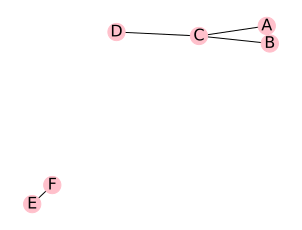

In [21]:
nx.draw(disconnected, **draw_params)

In [22]:
connected(disconnected, "A", "B")

True

In [23]:
connected(disconnected, "A", "E")

False

In [24]:
assert connected(disconnected, "A", "B")
assert connected(disconnected, "A", "C")
assert connected(disconnected, "A", "D")
assert connected(disconnected, "B", "C")
assert connected(disconnected, "B", "D")
assert connected(disconnected, "E", "F")
assert not connected(disconnected, "A", "E")
assert not connected(disconnected, "A", "F")
assert not connected(disconnected, "D", "E")
assert not connected(disconnected, "D", "F")
assert not connected(disconnected, "C", "E")

- Question: in what order were the nodes traversed?

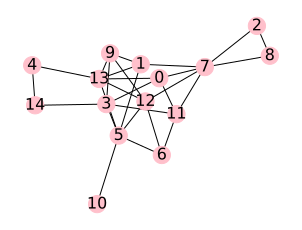

In [25]:
erg = nx.erdos_renyi_graph(15, 0.2, seed=40)
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

In [26]:
connected(erg, 14, 0, verbose=True)

At node 3
At node 0


True

- Note the order: 
  - It's taking 0's first neighbour, which is 3
  - Then 3's first neighbour, which is 5
  - Then 5's first neighbour, which is 1
  - This is called **[depth first search](https://en.wikipedia.org/wiki/Depth-first_search) (DFS)** because we go deep into the graph
  - To do in class: draw the recursion tree.

- What if this was a huge graph, and the two nodes were right next to each other?
  - The algorithm might be extremely inefficient.

**Question:** Why not do a brute-force search?

## Break (5 min)

## Stacks and queues (5 min)

- Let's briefly discuss some data structures we'll need shortly.
- We want a data structure that we can put things into, and then retrieve them later.
- A [stack](https://en.wikipedia.org/wiki/Stack_(abstract_data_type)) does with with the "last in, first out" (LIFO) mentality - like a stack of books or plates.

In [27]:
class Stack:
    """A stack data structure."""

    def __init__(self):
        self.data = list()

    def push(self, item):
        """
        Adds a new item to the top of the stack.
        
        Parameters
        ----------
        item : object
           An item added to the stack
        """
        self.data.append(item)

    def pop(self):
        """
        Removes the item that is at the top of the stack and returns the item.

        Returns
        -------
        object 
             The item that was last added to the stack.

        Examples
        --------
        >>> stack = Stack()
        >>> stack.push(1)
        >>> stack.push([1, 2, "dog"])
        >>> stack.push("popcorn")
        >>> stack.pop()
        'popcorn'
        """
        return self.data.pop()

    def isEmpty(self):
        """ 
        Checks to see if the stack is empty.

        Returns
        -------
        bool 
             True if the stack contains no items, False otherwise.    

        Example
        --------
        >>> stack = Stack()
        >>> stack.isEmpty()
        True
        """
        return len(self.data) == 0
    
    def __str__(self):
        return self.data.__str__()

In [28]:
s = Stack()

s.push("first")
s.push("second")

print(s)

['first', 'second']


In [29]:
s.pop()

'second'

In [30]:
print(s)

['first']


In [31]:
s.push("third")
s.push("fourth")

In [32]:
print(s)

['first', 'third', 'fourth']


In [33]:
s.pop()

'fourth'

In [34]:
s.pop()

'third'

In [35]:
s.pop()

'first'

In [36]:
s.pop()

IndexError: pop from empty list

- Along with stacks we also have [queues](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)), which use "first in, first out" (FIFO) ordering.
  - e.g. an actual queue/lineup

In [37]:
class Queue:
    """A Queue data structure."""
    
    def __init__(self):
        self.data = list()

    def push(self, item):
        """
        Adds a new item to the end of the queue.
        
        Parameters
        ----------
        item : object
           An item added to the queue
        """
        
        self.data.append(item)

    def pop(self):
        """
        Removes the item that is at the front of the queue and returns the item.

        Returns
        -------
        object 
             The least recent item added to the queue.     

        Example
        --------
        >>> queue = Queue()
        >>> queue.push(1)
        >>> queue.push([1, 2, "dog"])
        >>> queue.push("popcorn")
        >>> queue.pop()
        '1'
        """
        return self.data.pop(0)

    def isEmpty(self):
        """ 
        Checks to see if the queue is empty. 

        Returns
        -------
        bool 
            True if the stack contains no items, False otherwise.    

        Example
        --------
        >>> queue = Queue()
        >>> queue.push(1)
        >>> Queue.isEmpty()
        False
        
        """
        return len(self.data) == 0
    
    def __str__(self):
        return self.data.__str__()

In [38]:
q = Queue()

q.push("first")  # often called "enqueue"
q.push("second")

print(q)

['first', 'second']


In [39]:
q.pop() # often called "dequeue"

'first'

In [40]:
print(q)

['second']


In [41]:
q.push("third")
q.push("fourth")

In [42]:
print(q)

['second', 'third', 'fourth']


In [43]:
while not q.isEmpty():
    print(q.pop())

second
third
fourth


## Graph searches: iterative implementation (15 min)

- Implementation:
  - Let's implement it non-recursively this time.
  - Every time we visit a node, we add its neighbours to the queue.
  - This ensures we'll visit the all the "distance 1 neighbours" before visiting any "distance 2 neighbours".

In [ ]:
def connected_bfs(g, node1, node2, verbose=False):
    """ 
    Given a NetworkX Graph g, and start node node1 
    and goal node node2, tests whether node1 and node2
    are connected in the graph g using breadth first search.
    If they are not connected, returns False.

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    verbose : bool
        if True, node location will be displayed while False will not
        (default is False)
    
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> connected_bfs(graph, 1, 0)
    True
    """
    
    q = Stack()
    q.push(node1)

    visited = {node1}

    while not q.isEmpty():
        v = q.pop()
        
        if verbose:
            print("At node", v)
            
        if v == node2:
            return True

        for v in g.neighbors(v):
            if v in visited:
                continue
#             if v not in visited:
            visited.add(v)
            q.push(v)

    return False

In [ ]:
connected_bfs(erg, 0, 14)

In [ ]:
connected_bfs(erg, 0, 14, verbose=True)

In [ ]:
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

- The beauty is that to turn this into DFS, we only need to change the `Queue` to a `Stack`.
  - Though the neighbours will be traversed in reverse order, so it's not exactly the same as our recursive DFS. We'll consider this optional.
- BFS can be used to determine the "distance" between nodes, by keeping track of the "neighbour depth".
- Here it is in `networkx`:

In [ ]:
nx.shortest_path_length(erg, 0, 14)

- This means it takes $2$ hops to get from node $0$ to node $14$.